# Dependencies

In [ ]:
import os
os.chdir('drive/MyDrive/modules')
!nvidia-smi

Sun Feb 13 14:29:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import keras
from keras.layers import Dense, Input, GlobalAveragePooling1D, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Activation, AveragePooling2D, Flatten
import argparse
from imutils import paths
from sklearn.metrics import recall_score, precision_score, f1_score, \
    accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay

from aspectawarepreprocessor import AspectAwarePreprocessor
from imagetoarraypreprocessor import ImageToArrayPreprocessor
from simpledatasetloader import SimpleDatasetLoader

from tensorflow.keras.optimizers import Adam,SGD
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model
from keras import backend as K, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers as L
import tensorflow as tf
# from keract import get_activations, display_activations
from matplotlib import pyplot

# Process Train Images

In [ ]:
parent = "/content/drive/MyDrive/Data/train_images/train_images"

labels_train = pd.read_csv("/content/drive/MyDrive/Data/labels_train.csv")

imagePaths = []
for path in labels_train['file_name']:
  wholePath = os.path.join(parent,path)
  imagePaths.append(wholePath)
sp = AspectAwarePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
X = sdl.load(imagePaths, verbose=1000)

Y_train = [l for l in labels_train['class_id']]

X_train, X_val, Y_train, Y_val = train_test_split(X,Y_train,test_size=0.33,shuffle=True)

X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

Y_train = tf.keras.utils.to_categorical(Y_train,num_classes=3)
Y_val = tf.keras.utils.to_categorical(Y_val,num_classes=3)

print(f"[INFO] Found {X_train.shape[0]} images for training with shape:{X_train.shape[1:]}.")
print(f"[INFO] Found {X_val.shape[0]} images for validation with shape:{X_val.shape[1:]}.")

[INFO] processed 1000/4672
[INFO] processed 2000/4672
[INFO] processed 3000/4672
[INFO] processed 4000/4672
[INFO] Found 3130 images for training with shape:(224, 224, 3).
[INFO] Found 1542 images for validation with shape:(224, 224, 3).


# Augment Data

In [ ]:
datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    width_shift_range=0.5,
    height_shift_range=0.2
)
datagen.fit(X_train)

# Callbacks

In [ ]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=0.0000001, verbose=1)


model_weights = 'robust_v7-e{epoch:04d}-loss{loss:.3f}-acc{acc:.3f}-valloss{val_loss:.3f}-valacc{val_acc:.3f}.h5'
checkpoint_filepath = os.path.join("/content/drive/MyDrive/Weights",model_weights)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)

calls = [lr_reducer,modelCheckpoint]

# **Robust Model**
- [source code](https://github.com/Wyverson/OutdoorSent)
- [Model paper](https://arxiv.org/abs/1509.06041)

In [ ]:
# Robust Image Sentiment Analysis Using
#  Progressively Trained and Domain Transferred Deep Networks
print('Robust selected')


model_version = "_v7.h5"
model_path = "/content/drive/MyDrive/Saved_Models/robust"
model_name = os.path.join(model_path,model_version)
if os.path.isfile(model_name):
  model = tf.keras.models.load_model(model_name)
  print('loading model')
else:
  print('creating model')
  input_tensor = L.Input(shape=(224,224,3))

  model = L.Conv2D(filters=96,
                          kernel_size=(11,11),
                          strides=4,
                          activation='relu')(input_tensor)
  model = L.Lambda(lambda a: tf.nn.lrn(input=a))(model)
  model = L.MaxPooling2D(pool_size=(6, 6), strides=2)(model)

  model = L.Conv2D(filters=256,
                          kernel_size=(5, 5),
                          strides=2,
                          activation='relu')(model)
  model = L.Lambda(lambda a: tf.nn.lrn(input=a))(model)
  model = L.MaxPooling2D(pool_size=(3, 3), strides=6)(model)

  model = L.Flatten()(model)
  model = L.Dense(units=1024, activation='relu')(model)
  model = L.Dropout(rate=0.2)(model)
  model = L.Dense(units=1024, activation='relu')(model)
  model = L.Dropout(rate=0.2)(model)
  model = L.Dense(units=24, activation='relu')(model)

  predictions = L.Dense(units=3, activation='softmax')(model)
              
  model = Model(inputs=[input_tensor], outputs=predictions)
  model.compile(
        optimizer=Adam(learning_rate=0.0001, decay=1e-6),
        loss="categorical_crossentropy",
        metrics=['acc']
    )
  model.save(model_name)
model.summary()

Robust selected
creating model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 224)       81536     
                                                                 
 lambda (Lambda)             (None, 54, 54, 224)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 224)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 256)       1433856   
                                                                 
 lambda_1 (Lambda)           (None, 11, 11, 256)       0         
                              

# Train

In [ ]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                    epochs=100,
                    verbose=1, 
                    validation_data=(X_val,Y_val),
                    callbacks=calls)

print("Saving Trained Model..")
model.save(model_name)

Epoch 1/100
98/98 [==============================] - 50s 405ms/step - loss: 1.0267 - acc: 0.4952 - val_loss: 0.8943 - val_acc: 0.5681 - lr: 1.0000e-04
Epoch 2/100
98/98 [==============================] - 39s 394ms/step - loss: 0.9039 - acc: 0.5799 - val_loss: 1.0568 - val_acc: 0.5097 - lr: 1.0000e-04
Epoch 3/100
98/98 [==============================] - 39s 398ms/step - loss: 0.8602 - acc: 0.6035 - val_loss: 0.8316 - val_acc: 0.6122 - lr: 1.0000e-04
Epoch 4/100
98/98 [==============================] - 39s 395ms/step - loss: 0.8447 - acc: 0.6029 - val_loss: 0.8328 - val_acc: 0.6161 - lr: 1.0000e-04
Epoch 5/100
98/98 [==============================] - 39s 394ms/step - loss: 0.8217 - acc: 0.6195 - val_loss: 0.8010 - val_acc: 0.6232 - lr: 1.0000e-04
Epoch 6/100
98/98 [==============================] - 39s 394ms/step - loss: 0.8257 - acc: 0.6150 - val_loss: 0.7764 - val_acc: 0.6219 - lr: 1.0000e-04
Epoch 7/100
98/98 [==============================] - 39s 396ms/step - loss: 0.8116 - acc: 0.61

# Plot models

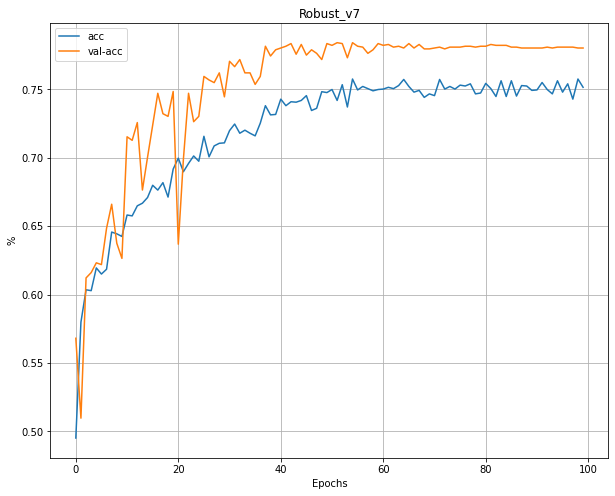

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Robust_v7')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)

# Evaluate

In [ ]:
scores = model.evaluate(X_val,Y_val)
print(f"Validation Loss :{scores[0]}")
print(f"Validation Accuracy :{scores[1]}")